<a href="https://colab.research.google.com/github/sambethune/causal_learning/blob/master/Week%208%20-%20MIMIC-3%20Configuration%20and%20Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIMIC-3 Analysis: Setup and First Approach

Let's examine an example subset of the MIMIC-3 database using the CausalNex package. This week we will focus on the basics of the dataset, getting things running in CausalNex as well as handling the problem of missing data. We note that in the weeks to come we will extend on variations of this same notebook, using it as a laboratory.

## Configuration and Cleaning

In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

In [0]:
% cd /content/drive/My Drive/SCIE3250 Journal/Week 8

Vitally important is that we revert to \``pandas 0.24.0`\` **after** installing causalnex. We will also need to restart our runtime (when using Google Colab) after installing the causalnex package.

In [0]:
! pip install causalnex
! pip install --upgrade pandas==0.24.0  # We require this version of pandas

In [0]:
files.upload()

In [10]:
import pandas as pd
df = pd.read_csv('mimic_day_blocks_ARDS2.csv', delimiter=',')
df.head()

,HADM_ID,CHARTDATE,BMI,RSC,PaO2/FiO2,PaCO2,Tidal_ml,Plateau_Pressure_cmH2O,Total_PEEP_cmH2O,PaO2,FiO2,ARDS,AGE,GENDER,AGE_INTERVALS,HCO3,Creatinine
0,100024,2170-09-19,29.52852,42.38806,2.28000,45.0,568.0,19.0,5.6,114.0,50.0,0,71,M,"(70, 75]",24.0,0.8
1,100035,2115-02-22,31.63272,25.00000,1.40000,97.0,500.0,30.0,10.0,84.0,60.0,1,37,M,"(35, 40]",33.0,1.2
2,100035,2115-02-23,31.63272,37.42857,0.93333,35.0,524.0,30.0,16.0,56.0,60.0,1,37,M,"(35, 40]",24.0,1.0
3,100035,2115-02-24,31.63272,50.72727,1.06154,54.0,558.0,24.0,13.0,69.0,65.0,1,37,M,"(35, 40]",30.0,0.8
4,100035,2115-02-25,31.63272,40.10000,2.10000,59.0,401.0,30.0,20.0,84.0,40.0,1,37,M,"(35, 40]",30.0,1.6


A quick rundown of our dataframe via quick Google searching:
- HADM_ID -> Some sort of patient admission ID.
- CHARTDATE -> Corresponding timestamp.
- BMI -> Body Mass Index; Underweight[<18.5], Healthy[18.5-24.9], Overweigh[25-29.9], Obese[>30].
- RSC -> Respiratory System Compliance
- PaO2/FiO2 -> Divisor PaO2 & FiO2; Normal[>200], Moderate[100-200], Severe[<100].
- PaCO2 -> Partial CO2 pressure, can indicate respiratory issues. Low[<75], Healthy[75-100], High[>100]
- Tidal_ml -> Air intake per cycle; usually recorded with body mass in ml/kg. Less for existing conditions etc.
- Plateau_Pressure_cmH2O -> Alveolar pressure; Healthy[<30], Risk[>30]
- Total_PEEP_cmH2O -> Put into ~5 bins.
- PaO2 -> Partial O2 pressure; Low[<80], Healthy [80-100], High[>100].
- Fraction of inspired O2 -> Oxygen enriched air, content; Guess that Normal[>30], High[>30].
- ARDS -> ARDS Binary; Yes[1], No[0].
- HCO3 -> Bicarbonate dosage, measures acid imbalance; ~4 bins.
- Creatinine -> Measures kidney health; Low[0.6], Healthy[0.6-1.2], High[>1.2].


We digitalise our discrete variables using SciKit Learn's pre-processing module, also creating a copy of our dataframe \``df_e`\` which we will manipulate from here on in.

In [12]:
import numpy as np
df_e = df.copy()

non_numeric_columns = \
list(df_e.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    df_e[col] = le.fit_transform(df_e[col])

df_e.head(5)

,HADM_ID,CHARTDATE,BMI,RSC,PaO2/FiO2,PaCO2,Tidal_ml,Plateau_Pressure_cmH2O,Total_PEEP_cmH2O,PaO2,FiO2,ARDS,AGE,GENDER,AGE_INTERVALS,HCO3,Creatinine
0,100024,5121,29.52852,42.38806,2.28000,45.0,568.0,19.0,5.6,114.0,50.0,0,71,1,11,24.0,0.8
1,100035,1012,31.63272,25.00000,1.40000,97.0,500.0,30.0,10.0,84.0,60.0,1,37,1,4,33.0,1.2
2,100035,1013,31.63272,37.42857,0.93333,35.0,524.0,30.0,16.0,56.0,60.0,1,37,1,4,24.0,1.0
3,100035,1014,31.63272,50.72727,1.06154,54.0,558.0,24.0,13.0,69.0,65.0,1,37,1,4,30.0,0.8
4,100035,1015,31.63272,40.10000,2.10000,59.0,401.0,30.0,20.0,84.0,40.0,1,37,1,4,30.0,1.6


We do not wish to analyse temporal features features at this stage so we remove the \``HADM_ID`\` and \``CHARTDATE`\` parameters.

In [0]:
drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

Missing values are present in the data as both zeros and infinities; additionally some entries present typing errors such as missing digits. Accordingly we first impute the infinities as \``nan`\`, intending to later change all \``nan`\` values to the mean for that parameter. At a later stage, we could even apply K-means clustering in the place of the parameter mean.

We then wish to eliminate outliers and zero values - but not on discrete variables! To avoid this we isolate the continuous variables before filtering the values further than 3 standard deviations from the mean by replacing them with \``nan`\`. Lastly we impute the \``nan`\` values as planned using SciKit Learn's imputer from the pre-processing module.

In [0]:
# Store parameter labels of df_enc, we need to be able to restore these after 
# applying the fit_transform method
my_columns = df_e.columns

In [0]:
# Replace infinities with nan
df_e.replace([-np.inf, np.inf], np.nan, inplace=True)

# Do not remove zeroes from discrete variables
cols_clean = ['BMI', 'RSC', 'PaO2/FiO2', 'PaCO2', 'Tidal_ml', \
  'Plateau_Pressure_cmH2O', 'Total_PEEP_cmH2O', 'PaO2', 'FiO2', 'ARDS', 'AGE']

# Replace outliers 3 standard deviations or more away with nan
for col in cols_clean:
  df_e[col] = df_e[col].mask(df_e[col].values - df_e[col].mean() > \
    3*df_e[col].std(), other=np.nan)
  
# Impute all nan as parameter mean
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_e = pd.DataFrame(imp.fit_transform(df_e), columns=my_columns)

We now scale our data to prepare for modelling using the SciKit Learn basic scaler. There are many others available and we will consider exploring them in the weeks to come. Our dataframe is copied and labelled \``df_e_cont`\` given its intended use: development of an SCM is best performed with continuous features.

In [0]:
from sklearn import preprocessing

df_e_cont = pd.DataFrame(preprocessing.scale(df_e), columns=my_columns)

For the creation of our Bayesian network however we will require discretised, classified data. Here we use a numeric split point technique, though we may change this later on to a quantile method if that seems to show greater promise. We note that the split points are in accordance with our earlier description of each parameter.

In [0]:
df_e_disc = df_e.copy()

from causalnex.discretiser import Discretiser

df_e_disc['BMI'] = Discretiser(method='fixed',
  numeric_split_points=[18.5, 25, 30]).transform(df_e_disc['BMI'].values)

df_e_disc['PaO2/FiO2'] = Discretiser(method='fixed',
  numeric_split_points=[100, 200]).transform(df_e_disc['PaO2/FiO2'].values)

df_e_disc['PaCO2'] = Discretiser(method='fixed',
  numeric_split_points=[75, 100]).transform(df_e_disc['PaCO2'].values)

df_e_disc['Plateau_Pressure_cmH2O'] = Discretiser(method='fixed',
  numeric_split_points=[30]).\
  transform(df_e_disc['Plateau_Pressure_cmH2O'].values)

df_e_disc['PaO2'] = Discretiser(method='fixed',
  numeric_split_points=[80, 100]).transform(df_e_disc['PaO2'].values)

df_e_disc['FiO2'] = Discretiser(method='fixed',
  numeric_split_points=[30]).transform(df_e_disc['FiO2'].values)

df_e_disc['Creatinine'] = Discretiser(method='fixed',
  numeric_split_points=[0.6, 1.2]).transform(df_e_disc['Creatinine'].values)

df_e_disc['RSC'] = Discretiser(method='quantile',
  num_buckets=5).fit_transform(df_e_disc['RSC'].values)

df_e_disc['Tidal_ml'] = Discretiser(method='quantile',
  num_buckets=5).fit_transform(df_e_disc['Tidal_ml'].values)

df_e_disc['Total_PEEP_cmH2O'] = Discretiser(method='quantile',
  num_buckets=5).fit_transform(df_e_disc['Total_PEEP_cmH2O'].values)

df_e_disc['HCO3'] = Discretiser(method='quantile',
  num_buckets=5).fit_transform(df_e_disc['HCO3'].values)

To use the \``Discretiser`\` class effectively and create readable results we will need to manually map each split onto a label using dictionaries.

In [0]:
BMI_map = {0: 'Underweight', 1: 'Normal', 2: 'Overweight', 3: 'Obese'}

PaO2FiO2_map = {0: 'Low PaO2/FiO2', 1: 'Normal PaO2/FiO2', 2: 'High PaO2/FiO2'}

PaCO2_map = {0: 'Low PaCO2', 1: 'Normal PaCO2', 2: 'High PaCO2'}

Plateau_Pressure_cmH2O_map = {0: 'Normal Plateau_Pressure_cmH2O', 
  1: 'High Plateau_Pressure_cmH2O'}

PaO2_map = {0: 'Low PaO2', 1: 'Normal PaO2', 2: 'High PaO2'}

FiO2_map = {0: 'Normal FiO2', 1: 'High FiO2'}

Creatinine_map = {0: 'Low Creatinine', 1: 'Normal Creatinine', 
  2: 'High Creatinine'}

RSC_map = {0: 'RSC 1', 1: 'RSC 2', 2: 'RSC 3', 3: 'RSC 4', 4: 'RSC 5'}

Tidal_ml_map = {0: 'Tidal_ml 1', 1: 'Tidal_ml 2', 2: 'Tidal_ml 3', 3: 
  'Tidal_ml 4', 4: 'Tidal_ml 5'}

Total_PEEP_cmH2O_map = {0: 'Total_PEEP_cmH2O 1', 1: 'Total_PEEP_cmH2O 2', 
  2: 'Total_PEEP_cmH2O 3', 3: 'Total_PEEP_cmH2O 4', 4: 'Total_PEEP_cmH2O 5'}

HCO3_map = {0: 'HCO3 1', 1: 'HCO3 2', 2: 'HCO3 3', 3: 'HCO3 4', 4: 'HCO3 5'}

In [0]:
df_e_disc["BMI"] = df_e_disc["BMI"].map(BMI_map)

df_e_disc["PaO2/FiO2"] = df_e_disc["PaO2/FiO2"].map(PaO2FiO2_map)

df_e_disc["PaCO2"] = df_e_disc["PaCO2"].map(PaCO2_map)

df_e_disc["Plateau_Pressure_cmH2O"] = \
  df_e_disc["Plateau_Pressure_cmH2O"].map(Plateau_Pressure_cmH2O_map)

df_e_disc["PaO2"] = df_e_disc["PaO2"].map(PaO2_map)

df_e_disc["FiO2"] = df_e_disc["FiO2"].map(FiO2_map)

df_e_disc["Creatinine"] = df_e_disc["Creatinine"].map(Creatinine_map)

df_e_disc["RSC"] = df_e_disc["RSC"].map(RSC_map)

df_e_disc["Tidal_ml"] = df_e_disc["Tidal_ml"].map(Tidal_ml_map)

df_e_disc["Total_PEEP_cmH2O"] = \
  df_e_disc["Total_PEEP_cmH2O"].map(Total_PEEP_cmH2O_map)

df_e_disc["HCO3"] = df_e_disc["HCO3"].map(HCO3_map)

## SCM

Next we will see if we can create a simple SCM.

In [0]:
! apt-get install -y graphviz-dev  # This step is essential in Google Colab.
! pip install pygraphviz

In [0]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import warnings
warnings.filterwarnings('ignore')

In [0]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(df_e_cont)

We develop SCM's at a range of thresholds to observe the robustness of our data. Just as with \``df`\` and \``df_e`\` we create a 'dummy' structural model \``sm_t`\` to avoid reinitialising \``sm`\` using \``from_pandas`\` as this is a time consuming operation. We start out with a high threshold of 0.8.

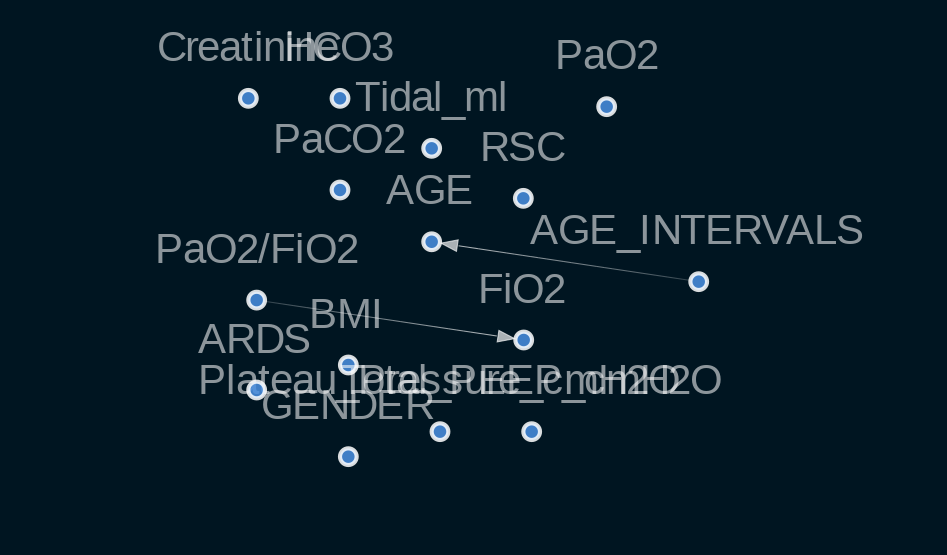

In [27]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.8)

viz = plot_structure(
    sm_t,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

Seeing that our data is not robust enough at this level, we lower the threshold to 0.5 and take another look.

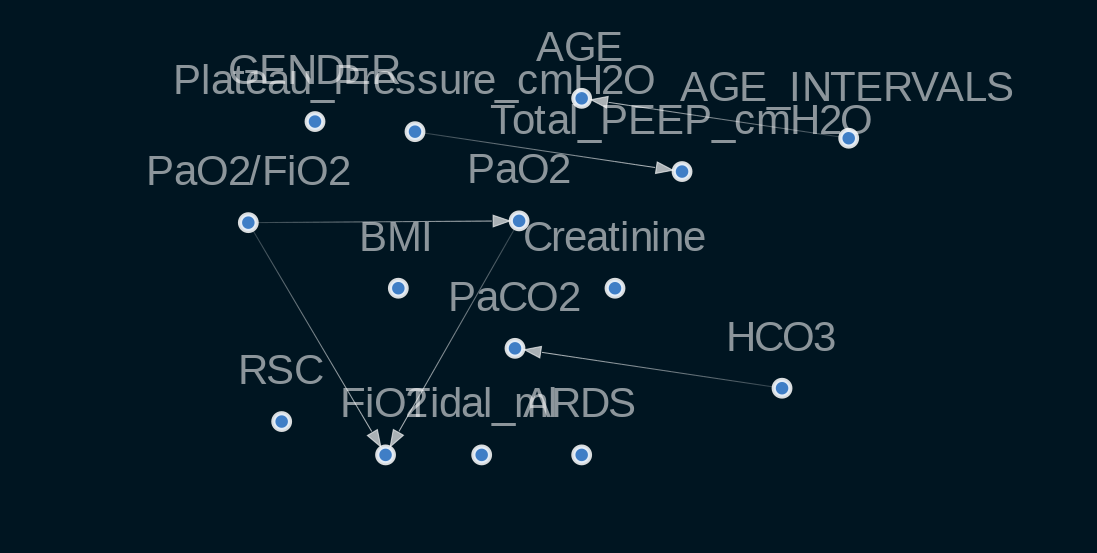

In [28]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.5)

viz = plot_structure(
    sm_t,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

With the exception of the two edges \``HCO3`\`-\``PaCO2`\` and \``Plateau_Pressure_cmH2O`\`-\``Total_PEEP_cmH2O`\` we observe only trivial dependencies. Accordingly we now try at a threshold of 0.3.

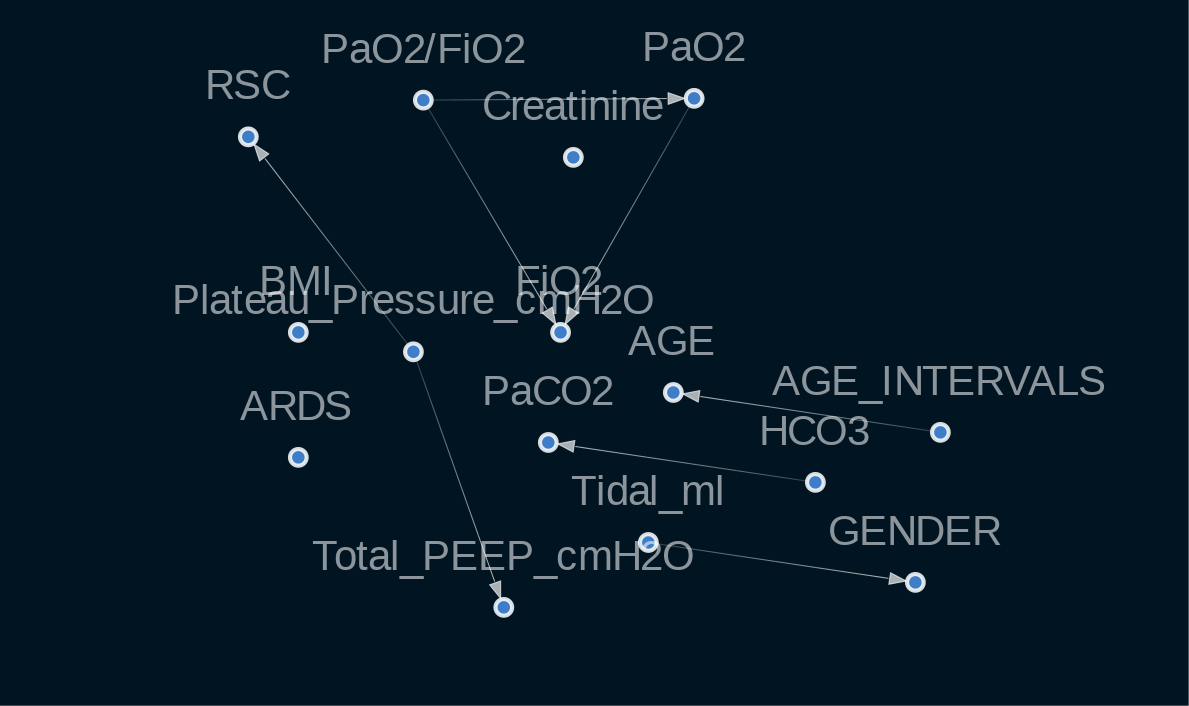

In [29]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.3)

viz = plot_structure(
    sm_t,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

This time we have an interesting chain but also come across our first clearly erroneous edge: \``Tidal_ml`\` cannot be causal for \``GENDER`\`. We are beginning to see that in this regime, our data may be more or less causally spurious. Nevertheless we check at thresholds of 0.2 and 0.1.

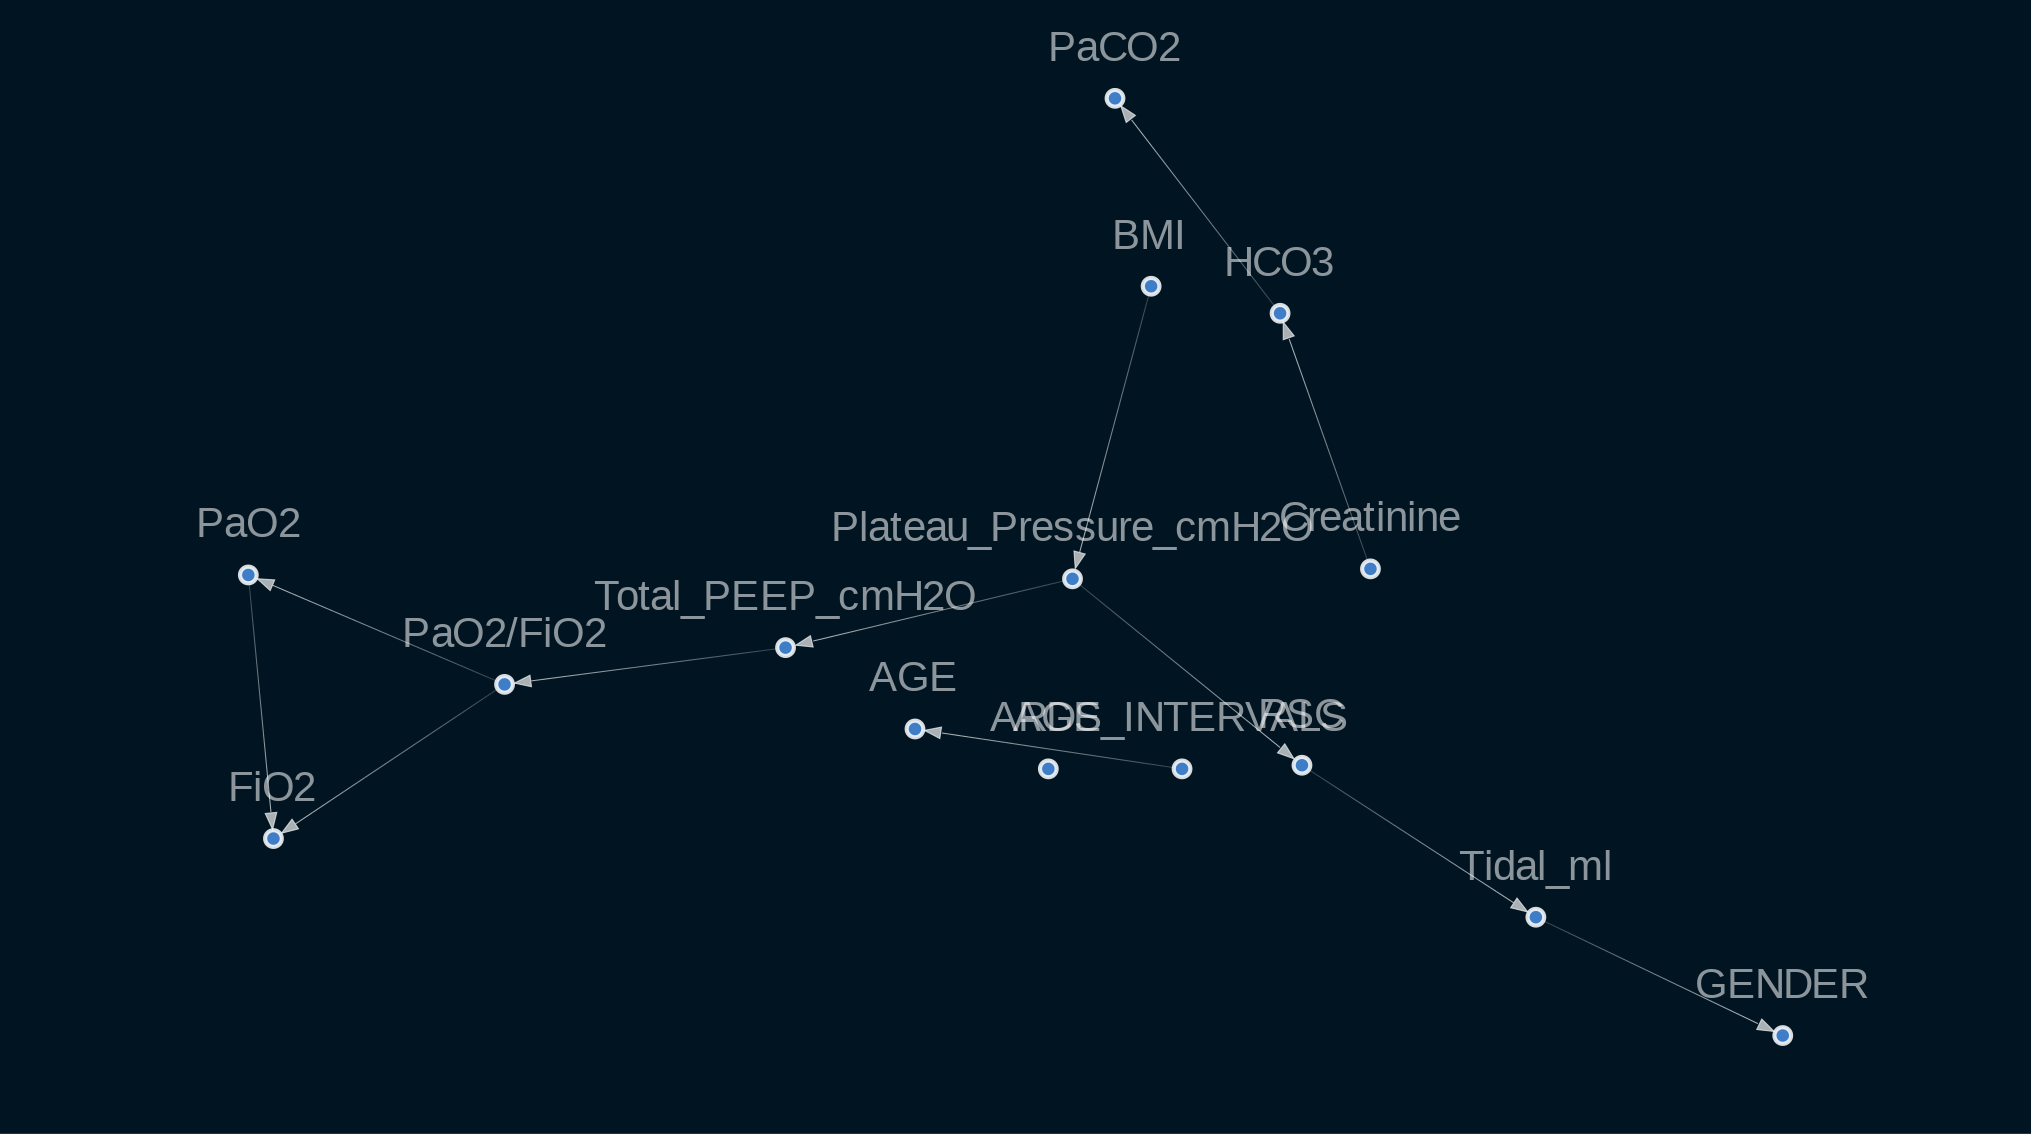

In [30]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.2)

viz = plot_structure(
    sm_t,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

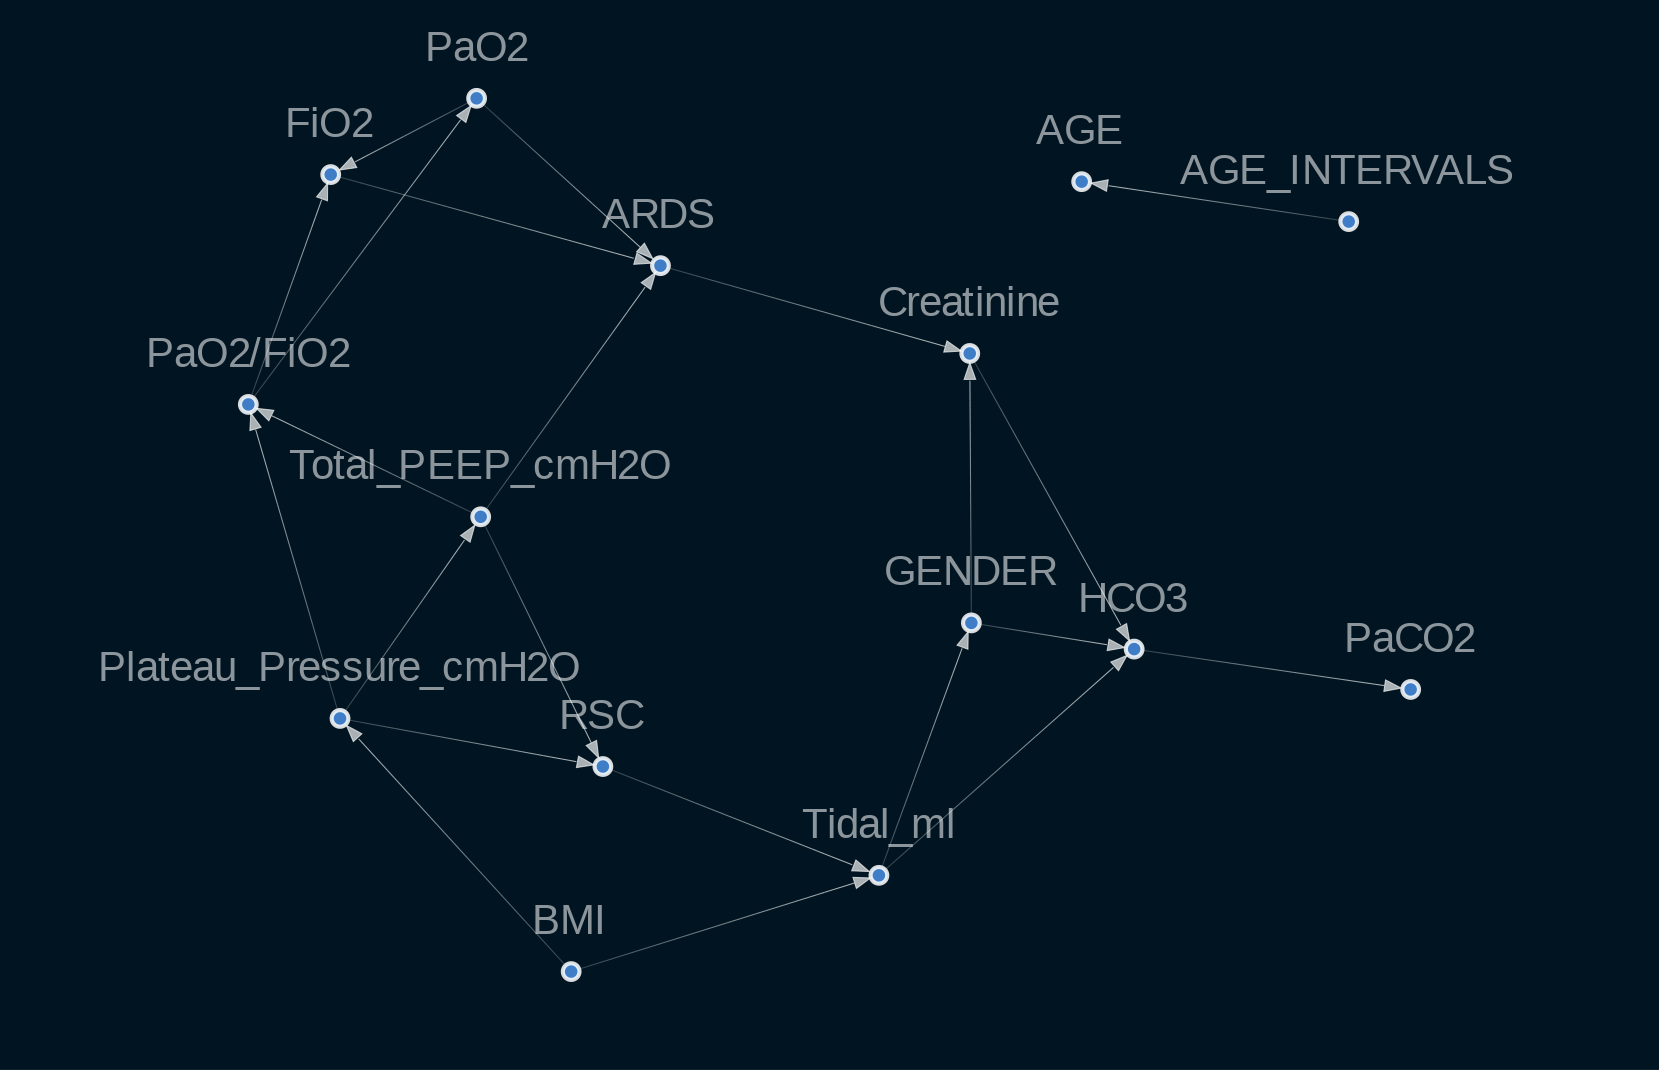

In [31]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.1)

viz = plot_structure(
    sm_t,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

Our SCM at a threshold of 0.1 is interesting but trivial given its threshold. At a threshold of 0.2 however the graph is slightly more credible. Seeing that all graphs bar the largest are trivial, we have another look.

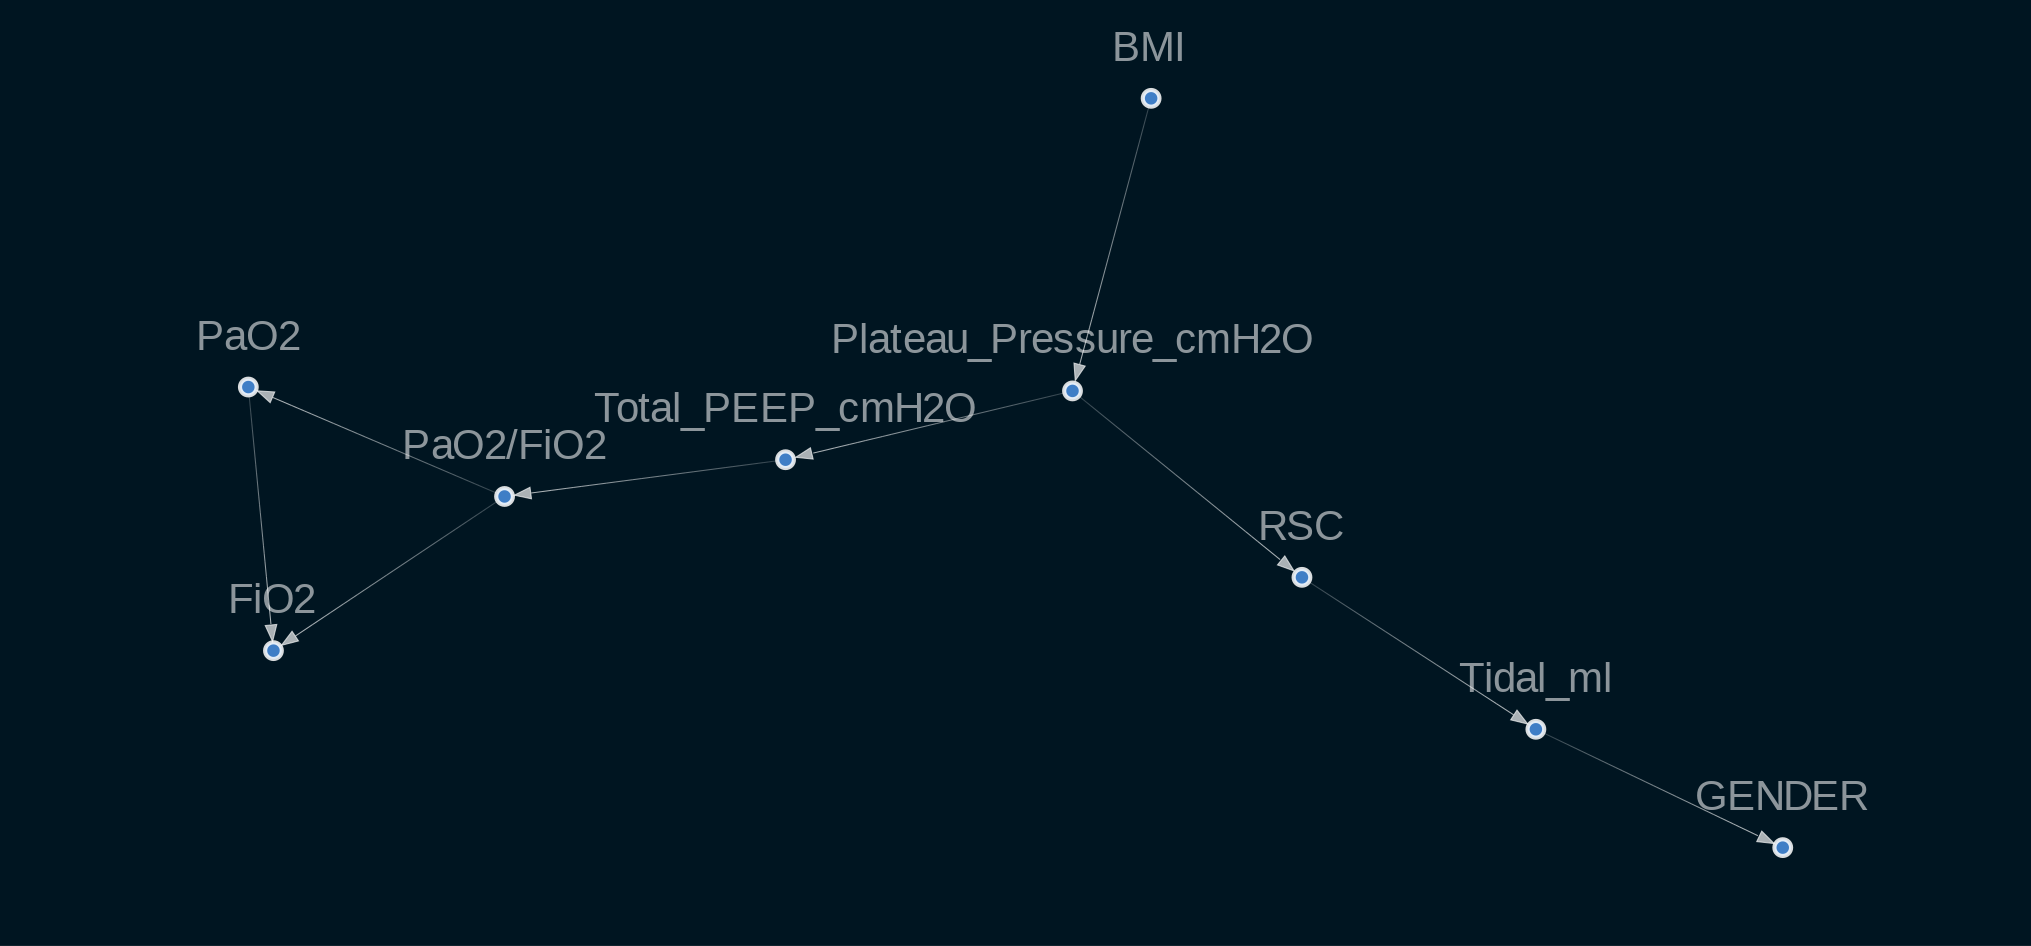

In [33]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.2)
sm_t = sm_t.get_largest_subgraph()

viz = plot_structure(
    sm_t,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

We see that the triangle to the left is trivial and decide to ignore it for now. The edge \``Tidal_ml`\`-\``GENDER`\` however is wrong and so we ban it before remodelling.

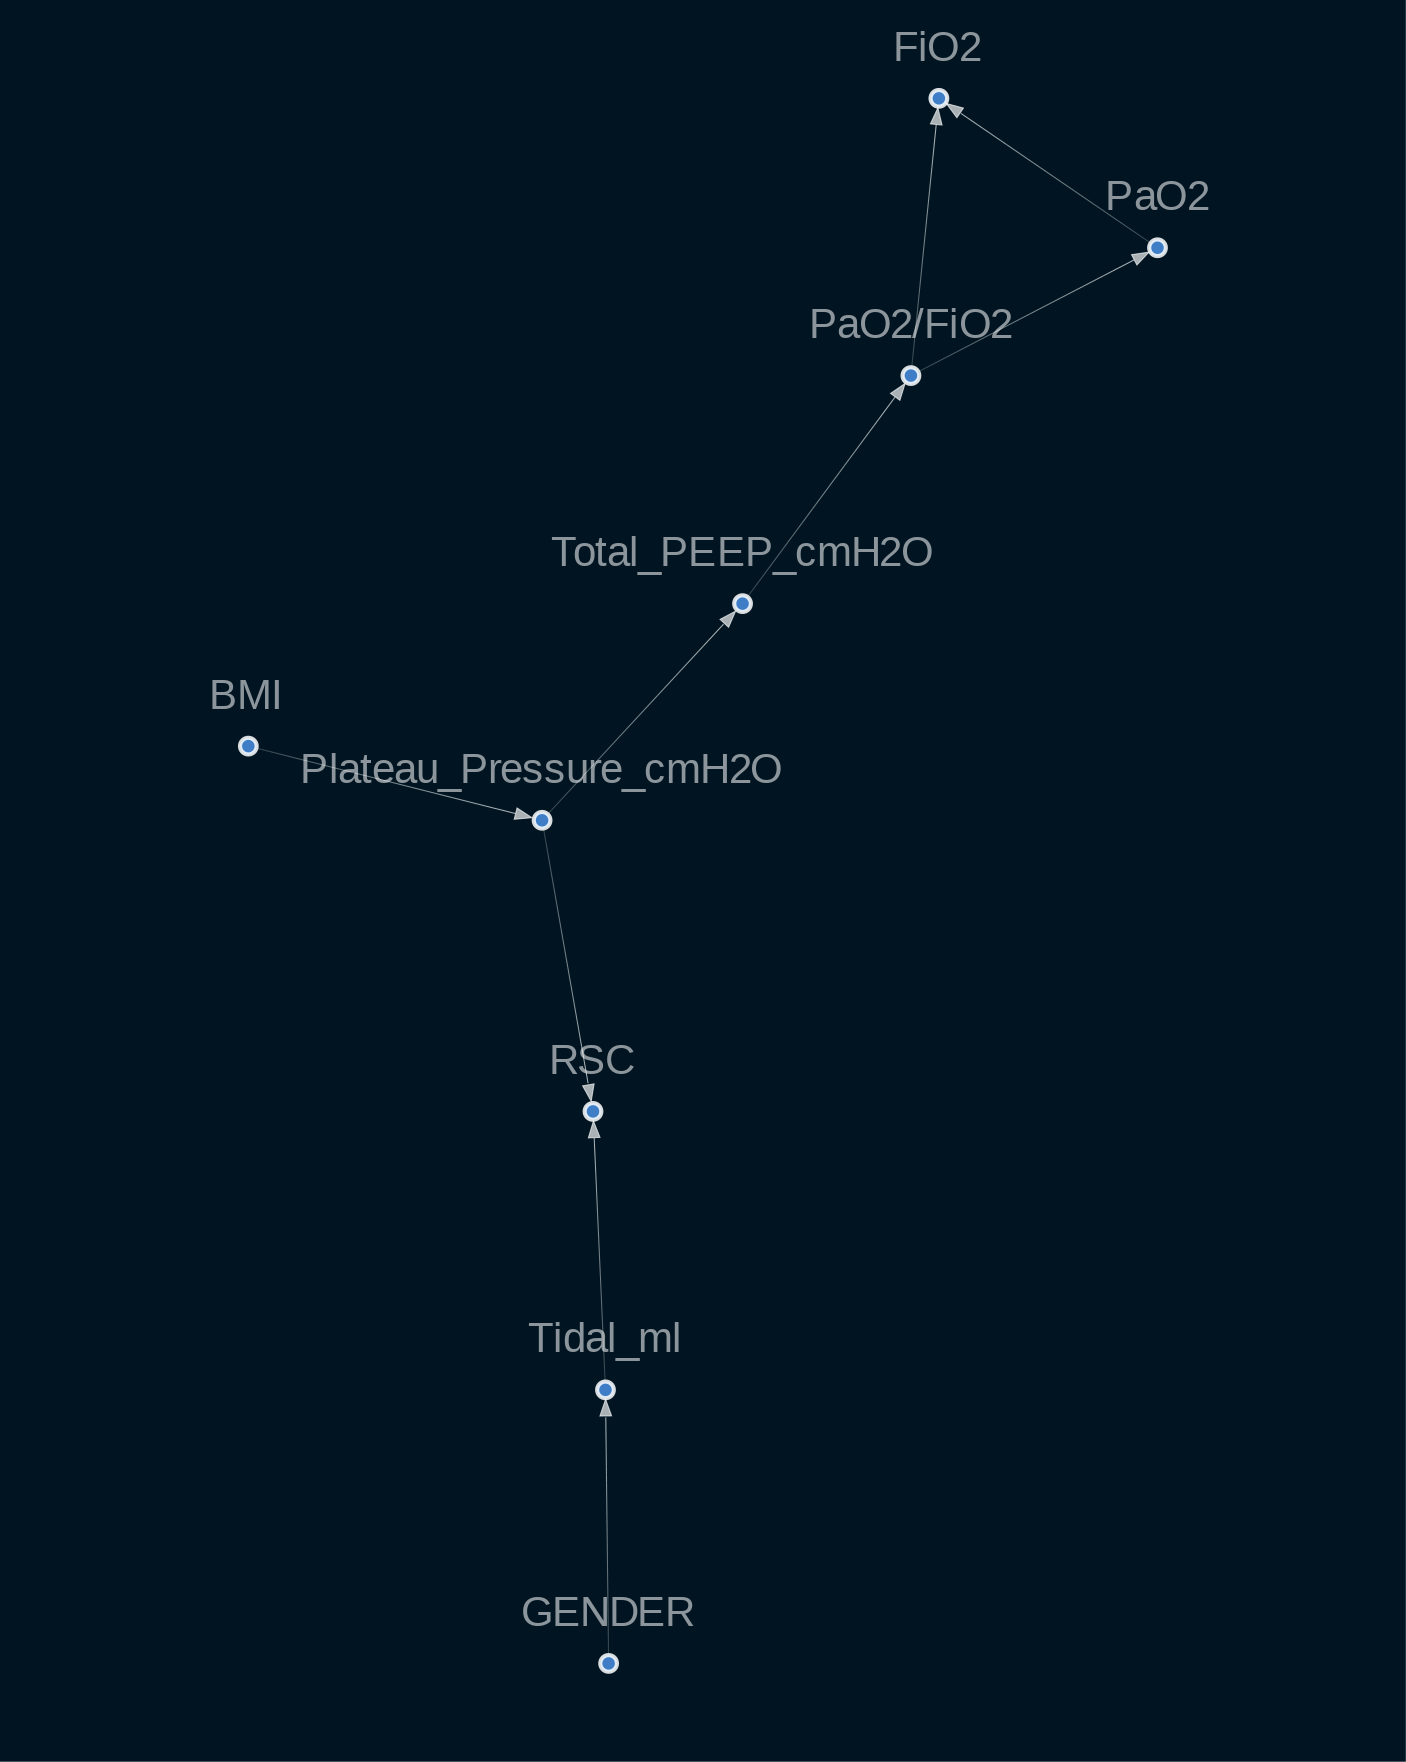

In [35]:
sm_t = from_pandas(df_e_cont, tabu_edges=[("Tidal_ml", "GENDER")], \
  w_threshold=0.2)
sm_t = sm_t.get_largest_subgraph()

viz = plot_structure(
    sm_t,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

This is interesting but we note that the \``tabu_edges`\` initialisation parameter of our SCM bans only one specific edge. Perhaps a more useful option is to define a node as being not a child or not a parent, for which we have \``tabu_child_nodes`\` and \``tabu_parent_nodes`\`. We demonstrate \``tabu_child_nodes`\` on \``GENDER`\` below.

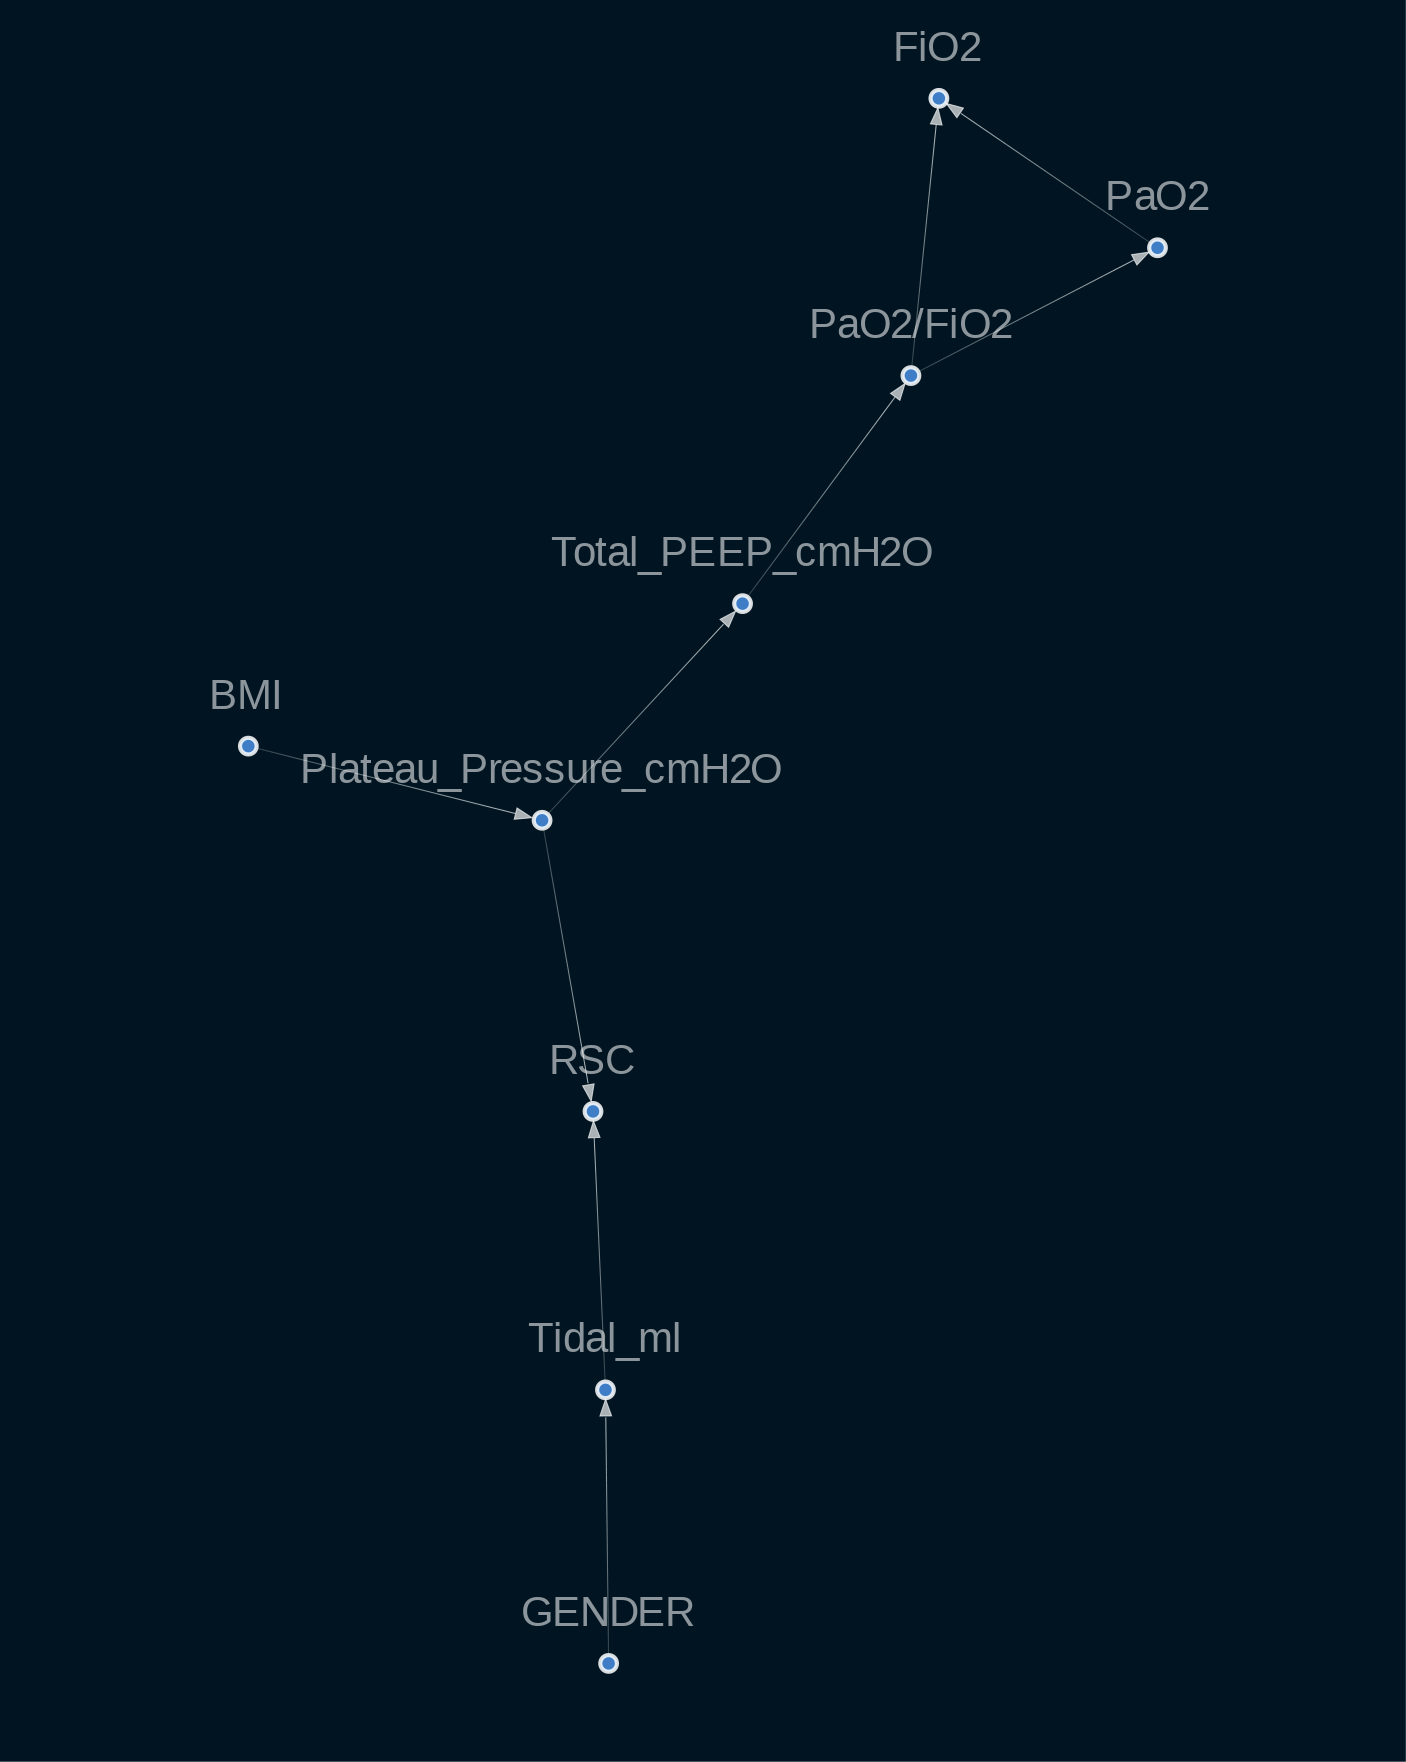

In [38]:
sm_t = from_pandas(df_e_cont, tabu_child_nodes=[("GENDER")], \
  w_threshold=0.2)
sm_t = sm_t.get_largest_subgraph()

viz = plot_structure(
    sm_t,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)